In [1]:
import os.path as osp

# Import for GCN
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer

# Import for GraphSAGE
from torch_geometric.datasets import Reddit
from torch_geometric.data import NeighborSampler
from torch_geometric.nn import SAGEConv

import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

본 tutorial은 pytorch-geometric의 여러 example들을 참고하여 짜깁기를 하여 제작하였습니다.
* gcn.py: https://github.com/rusty1s/pytorch_geometric/blob/master/examples/gcn.py
* reddit.py(SAGEConv): https://github.com/rusty1s/pytorch_geometric/blob/master/examples/reddit.py
* gnnexplainer.py: https://github.com/rusty1s/pytorch_geometric/blob/master/examples/gnn_explainer.py
* pytorch geometric: https://github.com/rusty1s/pytorch_geometric
* Rexying gnn explainer: https://github.com/RexYing/gnn-model-explainer

# GCN을 훈련한 뒤에 GNN Explainer를 적용하여, (Explanation = Subgraph)를 도출한다.

Pytorch Geometric에는 수많은 Graph Convolutional Layer가 구현되어 있다. 따라서 해당 Layer들을 활용하여 GCN을 구성한다.

In [81]:
class GCNModel(torch.nn.Module):
    def __init__(self, dataset, dim=16):
        super(GCNModel, self).__init__()
#         self.conv1 = GCNConv(dataset.num_features, dim)
#         self.conv2 = GCNConv(dim, dataset.num_classes)
        self.conv1 = SAGEConv(dataset.num_features, dim)
        self.conv2 = SAGEConv(dim, dataset.num_classes)
        # SAGEConv를 사용할 때 Neighbor Sampling이 들어가지 않아도 transductive하게 훈련한다면 상관없다고 생각한다.
        
        # 2 Layer GCN Conv
        # num_features > dim > num_classes
        
    def forward(self, x, edge_index, data=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training = self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

Dataset:
Dataset으로 GNNExplainer 논문에서는 Random Graph와 MUTAG / Reddit을 활용했으나, 본 예시에서는 Cora를 사용한다.

In [72]:
dataset = 'Cora'
path = osp.join(osp.dirname(osp.realpath('__file__')), '.', 'data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

In [73]:
gcn = GCNModel(dataset)

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = gcn.to(device)
data = data.to(device)
optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0)
], lr=0.01)  # Only perform weight-decay on first convolution.x, edge_index = data.x, data.edge_index

In [75]:
x, edge_index = data.x, data.edge_index

print(f'x data {x}')
print(f'edge_index {edge_index}')

x data tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
edge_index tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]], device='cuda:0')


In [76]:
edge_index.size()

torch.Size([2, 10556])

* x data에는 각 데이터의 feature가 포함되어 있는 것을 볼 수 있으며,
* edge_index는 (2, 10556)로 edge가 10556개 존재하는 것을 알 수 있다.

## Model Train

In [77]:
pbar = tqdm(total=201)
pbar.set_description(f'Epoch {epoch:02d}')

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pbar.update(1)

pbar.close()

print(f'GCN loss: {loss}')

Epoch 10: 100%|█████████▉| 200/201 [00:00<00:00, 208.71it/s]

GCN loss: 0.13691705465316772


In [78]:
def train(x, edge_index):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

@torch.no_grad()
def test(x, edge_index):
    model.eval()
    logits, accs = model(x, edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [79]:
pbar = tqdm(total=201)
pbar.set_description(f'Epoch {epoch:02d}')
best_val_acc = test_acc = 0
for epoch in range(1, 201):
    train(x, edge_index)
    train_acc, val_acc, tmp_test_acc = test(x, edge_index)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    pbar.update(1)
    if epoch % 20 == 0:
        print(log.format(epoch, train_acc, best_val_acc, test_acc)) 

pbar.close()

Epoch 200:  20%|██        | 41/201 [00:00<00:01, 122.80it/s]

Epoch: 020, Train: 1.0000, Val: 0.7820, Test: 0.7930
Epoch: 040, Train: 1.0000, Val: 0.7820, Test: 0.7930


Epoch 200:  46%|████▌     | 92/201 [00:00<00:00, 148.05it/s]

Epoch: 060, Train: 1.0000, Val: 0.7820, Test: 0.7930
Epoch: 080, Train: 1.0000, Val: 0.7820, Test: 0.7930


Epoch 200:  60%|██████    | 121/201 [00:00<00:00, 142.73it/s]

Epoch: 100, Train: 1.0000, Val: 0.7820, Test: 0.7930
Epoch: 120, Train: 1.0000, Val: 0.7840, Test: 0.8010


Epoch 200:  84%|████████▍ | 169/201 [00:01<00:00, 150.62it/s]

Epoch: 140, Train: 1.0000, Val: 0.7840, Test: 0.8010
Epoch: 160, Train: 1.0000, Val: 0.7840, Test: 0.8010


Epoch 200: 100%|█████████▉| 200/201 [00:01<00:00, 147.49it/s]

Epoch: 180, Train: 1.0000, Val: 0.7900, Test: 0.7980
Epoch: 200, Train: 1.0000, Val: 0.7900, Test: 0.7980


Explain node 5: 100%|██████████| 200/200 [00:01<00:00, 137.30it/s]


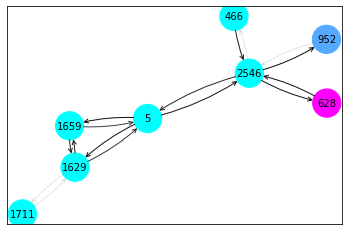

Explain node 35: 100%|██████████| 200/200 [00:01<00:00, 137.67it/s]


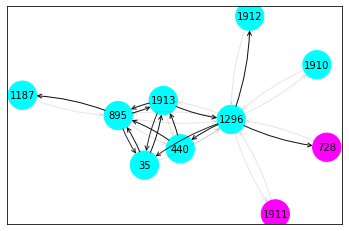

Explain node 65: 100%|██████████| 200/200 [00:01<00:00, 136.86it/s]


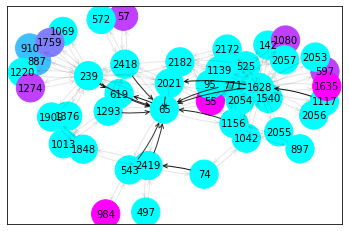

Explain node 95: 100%|██████████| 200/200 [00:01<00:00, 137.49it/s]


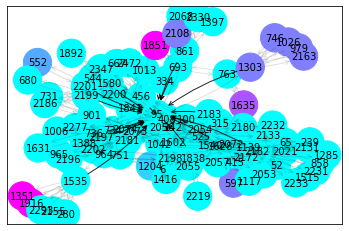

Explain node 125: 100%|██████████| 200/200 [00:01<00:00, 139.92it/s]


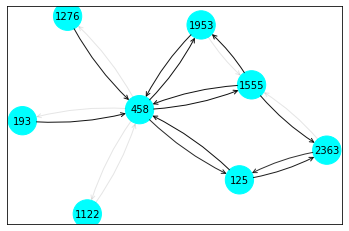

In [80]:
for node_idx in range(5, 140, 30):
    explainer = GNNExplainer(model, epochs=200)
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
    ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
    plt.show()

# GraphSAGE을 훈련한 뒤에 GNN Explainer를 적용하여, (Explanation = Subgraph)를 도출한다.

In [64]:
path = osp.join(osp.dirname(osp.realpath('__file__')), '.', 'data', 'Reddit')
dataset = Reddit(path)
data = dataset[0]

In [65]:
train_loader = NeighborSampler(data.edge_index, node_idx = data.train_mask, sizes = [25,10], batch_size=1024, shuffle=True, num_workers=12)
subgraph_loader = NeighborSampler(data.edge_index, node_idx = None, sizes=[-1], batch_size=1024, shuffle=False, num_workers=12)

In [63]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()

        self.num_layers = 2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1)

    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(dataset.num_features, 256, dataset.num_classes)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [67]:
x = data.x.to(device)
y = data.y.squeeze().to(device)

In [68]:
def train(epoch):
    model.train()

    pbar = tqdm(total=int(data.train_mask.sum()))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()
        out = model(x[n_id], adjs)
        loss = F.nll_loss(out, y[n_id[:batch_size]])
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(y[n_id[:batch_size]]).sum())
        pbar.update(batch_size)

    pbar.close()

    loss = total_loss / len(train_loader)
    approx_acc = total_correct / int(data.train_mask.sum())

    return loss, approx_acc


@torch.no_grad()
def test():
    model.eval()

    out = model.inference(x)

    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    results = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        results += [int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]

    return results


for epoch in range(1, 11):
    loss, acc = train(epoch)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')
    train_acc, val_acc, test_acc = test()
    print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Evaluating:   0%|          | 0/465930 [00:00<?, ?it/s]

Epoch 01, Loss: 0.5199, Approx. Train: 0.8909


Epoch 02:   0%|          | 0/153431 [00:00<?, ?it/s]

Train: 0.9508, Val: 0.9496, Test: 0.9493


Evaluating:   0%|          | 0/465930 [00:00<?, ?it/s]

Epoch 02, Loss: 0.4138, Approx. Train: 0.9248


Epoch 03:   0%|          | 0/153431 [00:00<?, ?it/s]

Train: 0.9486, Val: 0.9452, Test: 0.9445


Evaluating:   0%|          | 0/465930 [00:00<?, ?it/s]

Epoch 03, Loss: 0.4883, Approx. Train: 0.9234


Epoch 04:   0%|          | 0/153431 [00:00<?, ?it/s]

Train: 0.9532, Val: 0.9489, Test: 0.9483


Evaluating:   0%|          | 0/465930 [00:00<?, ?it/s]

Epoch 04, Loss: 0.5333, Approx. Train: 0.9256


Epoch 05:   0%|          | 0/153431 [00:00<?, ?it/s]

Train: 0.9570, Val: 0.9504, Test: 0.9502


Evaluating:   0%|          | 0/465930 [00:00<?, ?it/s]

Epoch 05, Loss: 0.5625, Approx. Train: 0.9258


Epoch 06:   0%|          | 0/153431 [00:00<?, ?it/s]

Train: 0.9552, Val: 0.9471, Test: 0.9485


Evaluating:   0%|          | 0/465930 [00:00<?, ?it/s]

Epoch 06, Loss: 0.5825, Approx. Train: 0.9257


Epoch 07:   0%|          | 0/153431 [00:00<?, ?it/s]

Train: 0.9577, Val: 0.9490, Test: 0.9487


Evaluating:   0%|          | 0/465930 [00:00<?, ?it/s]

Epoch 07, Loss: 0.5967, Approx. Train: 0.9282


Epoch 08:   0%|          | 0/153431 [00:00<?, ?it/s]

Train: 0.9604, Val: 0.9517, Test: 0.9500


Evaluating:   0%|          | 0/465930 [00:00<?, ?it/s]

Epoch 08, Loss: 0.5624, Approx. Train: 0.9302


Epoch 09:   0%|          | 0/153431 [00:00<?, ?it/s]

Train: 0.9612, Val: 0.9508, Test: 0.9514


Evaluating:   0%|          | 0/465930 [00:00<?, ?it/s]

Epoch 09, Loss: 0.5887, Approx. Train: 0.9300


Epoch 10:   0%|          | 0/153431 [00:00<?, ?it/s]

Train: 0.9598, Val: 0.9494, Test: 0.9483


Evaluating:   0%|          | 0/465930 [00:00<?, ?it/s]

Epoch 10, Loss: 0.5473, Approx. Train: 0.9321


Evaluating: 100%|██████████| 465930/465930 [00:22<00:00, 20425.22it/s]

Train: 0.9646, Val: 0.9512, Test: 0.9510


In [70]:
explainer = GNNExplainer(model, epochs=200)
node_idx = 120
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, adjs)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

NameError: name 'adjs' is not defined

GraphSAGE는 GCN과 다르게 edge_index list만 필요한 것이 아니라, Sampling된 이웃에 대한 기록도 미니 배치에 반영해야 하기 때문에 이것을 GNNExplainer로 나타낼 수 있을지 의문이다.